**Project**: Identify Real and Fake news

In [ ]:
#Library Required for this project
!pip install vaderSentiment
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
import seaborn as sns
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import StratifiedKFold



#Data: Read in data

In [ ]:
# Load the CSV file
file_path = "news_articles.csv"
df = pd.read_csv(file_path)

# Read data
print(df.columns)
print(df.head())

Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage'],
      dtype='object')
                 author                      published  \
0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
3                Fed Up  2016-11-01T05:22:00.000+02:00   
4                Fed Up  2016-11-01T21:56:00.000+02:00   

                                               title  \
0  muslims busted they stole millions in govt ben...   
1  re why did attorney general loretta lynch plea...   
2  breaking weiner cooperating with fbi on hillar...   
3  pin drop speech by father of daughter kidnappe...   
4  fantastic trumps  point plan to reform healthc...   

                                                text language  \
0  print they should pay all the back all t

#Data Cleaning

In [ ]:
#1.Drop extra colomuns

df = df.drop(columns=['title_without_stopwords', 'text_without_stopwords','site_url', 'main_img_url'])
print("Columns after droping not required columns")
print(df.columns)
#2.check for missing values
print("Missing values")
print(df.isnull().sum())
#3.drop rows with null values
df=df.dropna()
print("Missing values after droping")
print(df.isnull().sum())

Columns after droping not required columns
Index(['author', 'published', 'title', 'text', 'language', 'type', 'label',
       'hasImage'],
      dtype='object')
Missing values
author        1
published     0
title         0
text         46
language      2
type          2
label         2
hasImage      3
dtype: int64
Missing values after droping
author       0
published    0
title        0
text         0
language     0
type         0
label        0
hasImage     0
dtype: int64


#EDA

1. Count of news according to year,time and period of the day

In [ ]:
# Transform published date to analysis
# Define a function to parse and split the datetime string
def parse_datetime(value):
    try:
        # Parse datetime with timezone
        dt = pd.to_datetime(value, utc=True)
        return dt.date(), dt.time(), dt.tzinfo
    except Exception as e:
        # Handle invalid or missing datetime values
        return None, None, None

# Apply the function to split 'published' into three columns
df['date'], df['time'], df['timezone'] = zip(*df['published'].apply(parse_datetime))

# Drop the original 'published' column
df = df.drop(columns=['published'])

# Check the data after column split
print(df.head(5))

                 author                                              title  \
0     Barracuda Brigade  muslims busted they stole millions in govt ben...   
1  reasoning with facts  re why did attorney general loretta lynch plea...   
2     Barracuda Brigade  breaking weiner cooperating with fbi on hillar...   
3                Fed Up  pin drop speech by father of daughter kidnappe...   
4                Fed Up  fantastic trumps  point plan to reform healthc...   

                                                text language  type label  \
0  print they should pay all the back all the mon...  english  bias  Real   
1  why did attorney general loretta lynch plead t...  english  bias  Real   
2  red state  \nfox news sunday reported this mor...  english  bias  Real   
3  email kayla mueller was a prisoner and torture...  english  bias  Real   
4  email healthcare reform to make america great ...  english  bias  Real   

   hasImage        date             time timezone  
0       1.0  201

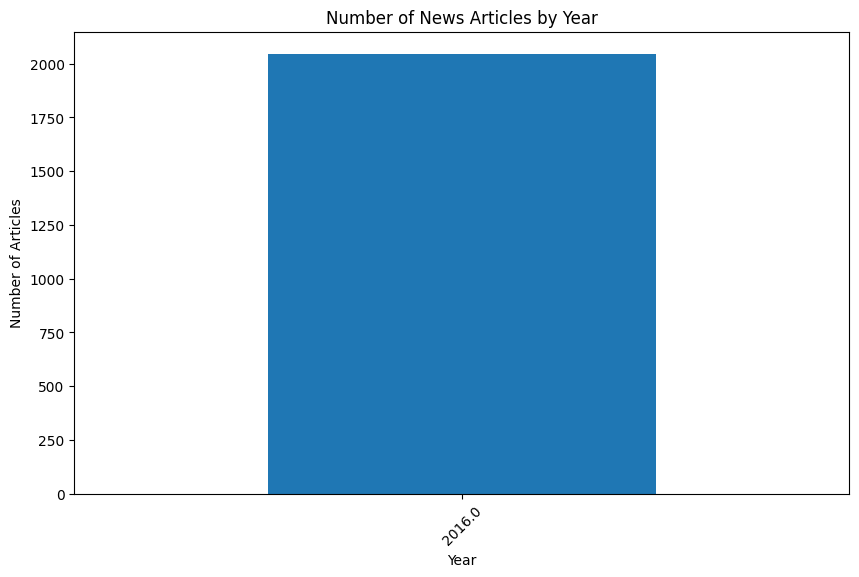

<Figure size 1200x600 with 0 Axes>

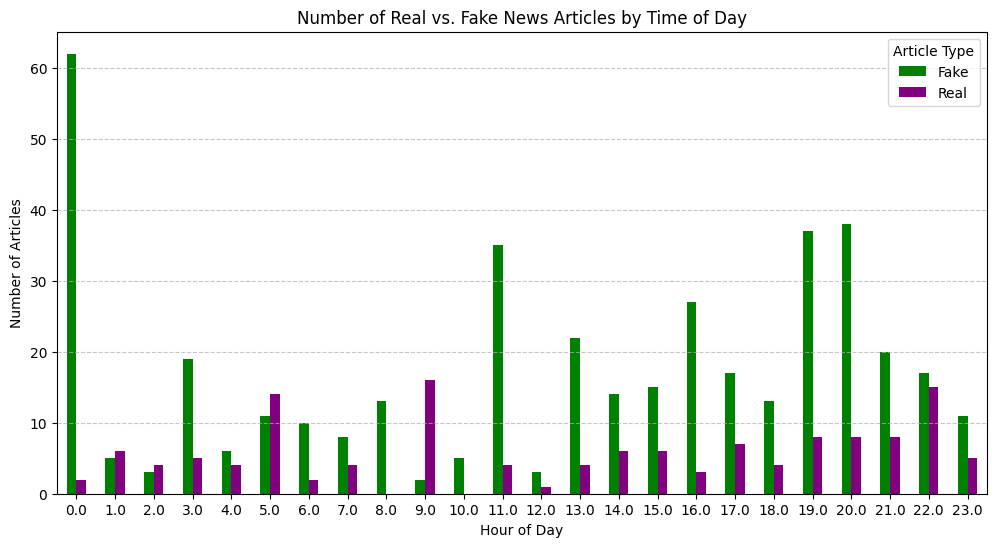

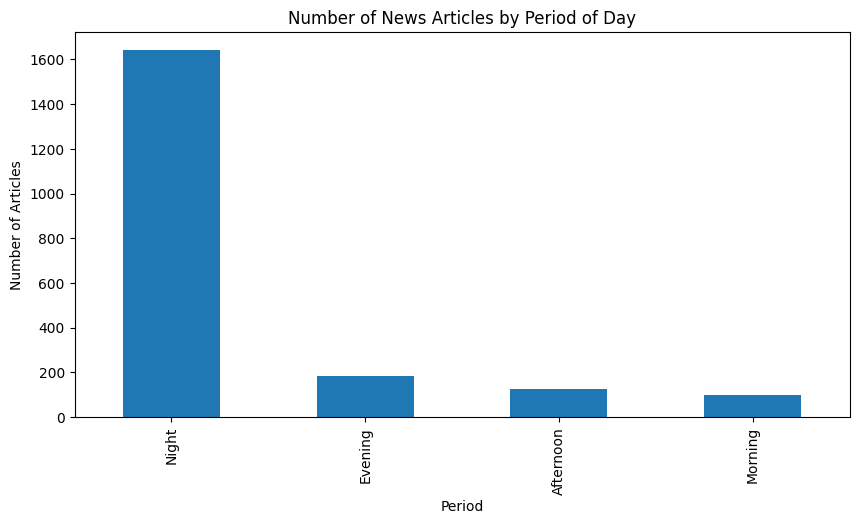

In [ ]:
#lets analysis year,data accoridng to time
#aritcles by year
#  'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Count the number of articles per year
articles_by_year = df['year'].value_counts().sort_index()

# Create a bar chart for articles by year
articles_by_year.plot(kind='bar', figsize=(10, 6))
plt.title('Number of News Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Extract the hour for aggregation
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour
#Group articles by hour and label (Real/Fake)
articles_by_hour_label = df.groupby(['hour', 'label']).size().unstack(fill_value=0)

# Plot the grouped bar chart with specified colors
plt.figure(figsize=(12, 6))
articles_by_hour_label.plot(kind='bar', figsize=(12, 6), color=['green', 'purple'])

# Customize the chart
plt.title("Number of Real vs. Fake News Articles by Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.legend(title="Article Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# Define time periods
def get_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to classify periods
df['period'] = df['hour'].apply(get_period)

# Count articles by period
articles_by_period = df['period'].value_counts()
#print("Number of News Articles by Period of Day")
# Bar plot for periods
articles_by_period.plot(kind='bar', figsize=(10,5))
plt.title('Number of News Articles by Period of Day')
plt.xlabel('Period')
plt.ylabel('Number of Articles')
plt.show()


2. checking how many news has image

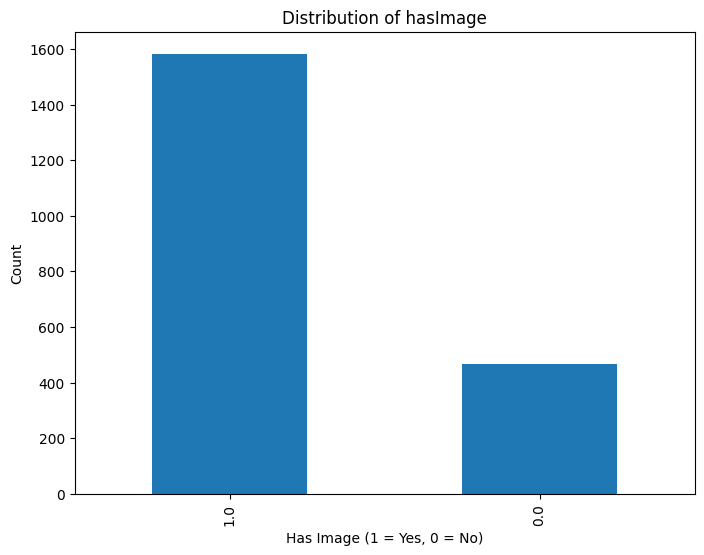

In [ ]:
# Bar plot for binary column
df['hasImage'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title('Distribution of hasImage')
plt.xlabel('Has Image (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

3. Check if our data is balance for further analysis

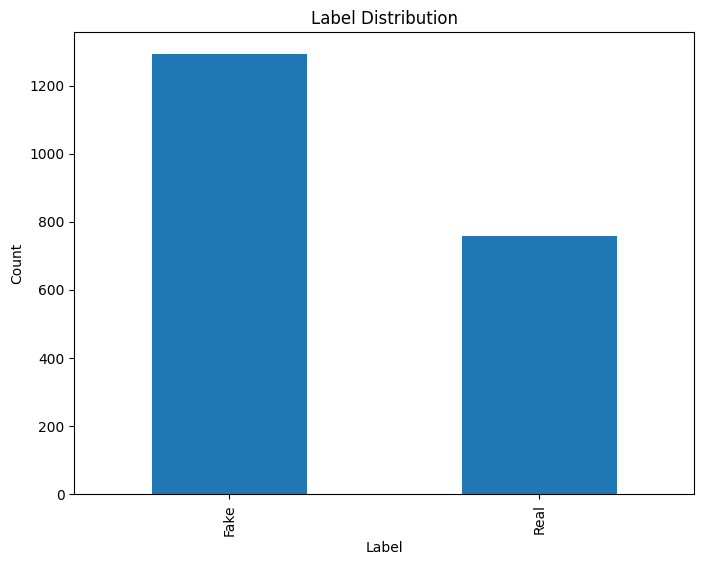

In [ ]:
df['label'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

4. category wise news distribution

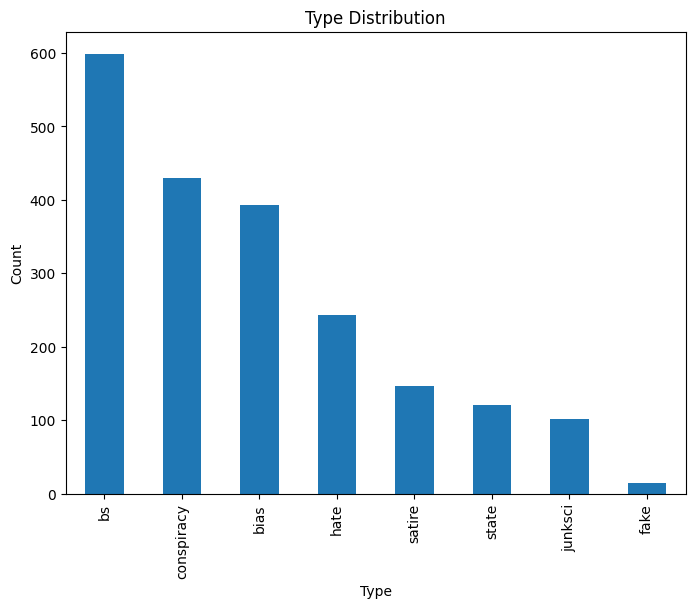

In [ ]:
df['type'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title('Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()


5. checking the length of news

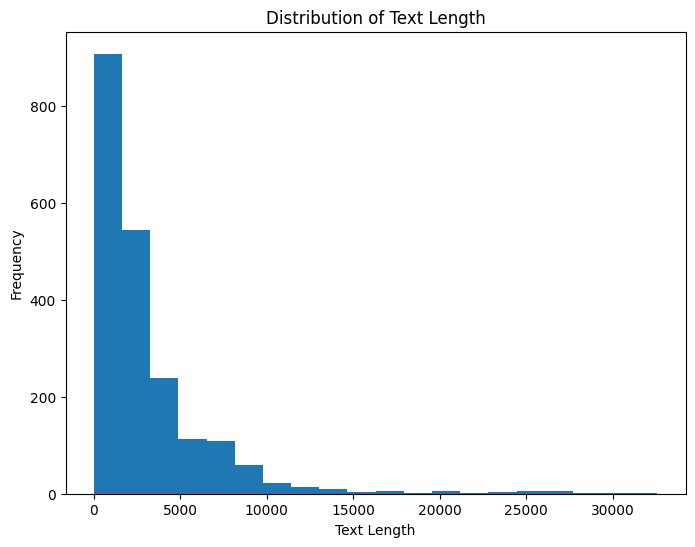

In [ ]:
# Add a new column for text length
df['text_length'] = df['text'].dropna().apply(len)

# Plot the distribution of text length
df['text_length'].plot(kind='hist', bins=20, figsize=(8, 6))
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

#Preprocessing of data:

Preprocessing function with lemmatization,stopwords removed, removed special charactor

In [ ]:
# Preprocessing function
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text_with_lemmatization(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove URLs and special characters
    text = re.sub(r"http\S+|www\S+|[^a-zA-Z\s]", " ", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and excessively long tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and 2 <= len(word) <= 15  # Filter by token length
    ]
    # Join tokens back into a single string
    return ' '.join(filtered_tokens)

# Apply preprocessing to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text_with_lemmatization)

# Preview the processed column
print(df[['text', 'processed_text']].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                                text  \
0  print they should pay all the back all the mon...   
1  why did attorney general loretta lynch plead t...   
2  red state  \nfox news sunday reported this mor...   
3  email kayla mueller was a prisoner and torture...   
4  email healthcare reform to make america great ...   

                                      processed_text  
0  print pay back money plus interest entire fami...  
1  attorney general loretta lynch plead fifth bar...  
2  red state fox news sunday reported morning ant...  
3  email kayla mueller prisoner tortured isi chan...  
4  email healthcare reform make america great sin...  


#WordCloud

1. For all News Articles

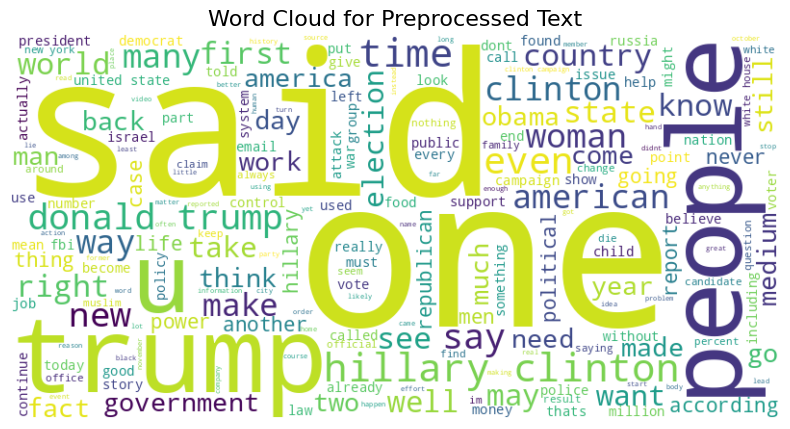

In [ ]:

# Combine all preprocessed text into a single string
all_text = ' '.join(df['processed_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Preprocessed Text', fontsize=16)
plt.show()

2. Seperate word cloud for Fake and Real News Articles

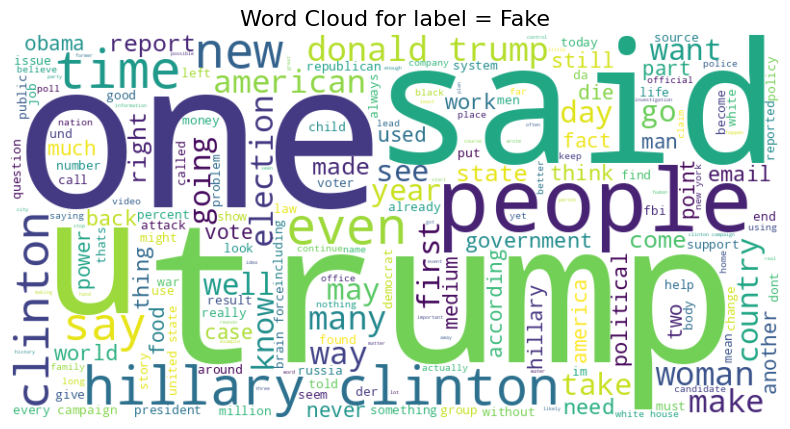

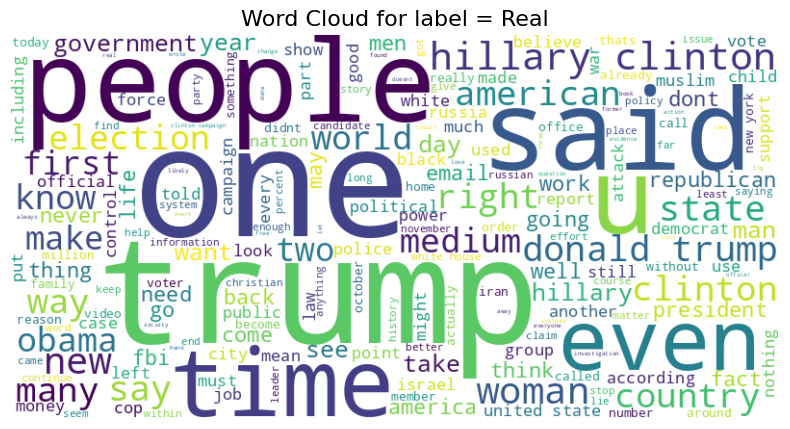

In [ ]:
# Group by 'label' and concatenate text
grouped_text = df.groupby('label')['processed_text'].apply(lambda x: ' '.join(x))

# Generate and display a word cloud for each 'label' category
for label, text in grouped_text.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for label = {label}', fontsize=16)
    plt.show()



Top 20 Most Common Words

[('trump', 4008), ('clinton', 3826), ('one', 2551), ('people', 2436), ('u', 2380), ('said', 2339), ('hillary', 2293), ('would', 2222), ('state', 2173), ('time', 1884), ('also', 1737), ('like', 1723), ('election', 1698), ('year', 1495), ('new', 1453), ('email', 1435), ('american', 1378), ('even', 1371), ('get', 1353), ('president', 1280)]


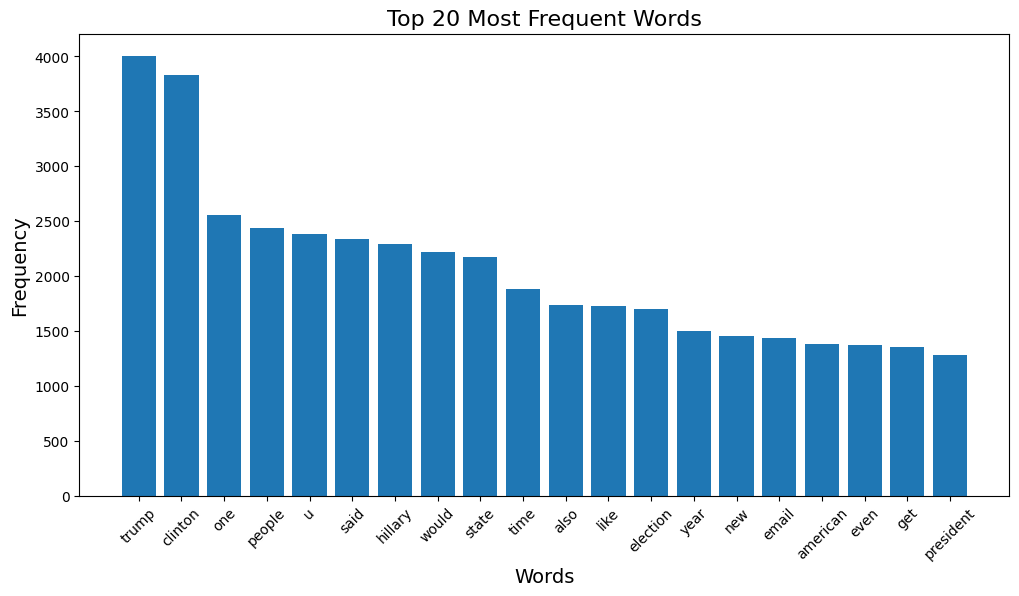

In [ ]:
# Tokenize the combined text
tokens = word_tokenize(all_text)

# Perform word frequency analysis using Counter
word_counts = Counter(tokens)

# Get the most common words
most_common_words = word_counts.most_common(20)  # Top 20 most common words
print(most_common_words)
# Extract the top 20 words and their frequencies
top_words = most_common_words[:20]
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Most Frequent Words', fontsize=16)
plt.xticks(rotation=45)
plt.show()


#K-Means Cluster

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize and fit the TfidfVectorizer
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=1, stop_words='english')

# Convert text data into TF-IDF vectors
X_tfidf = unigram_tfidf_vectorizer.fit_transform(df['processed_text'])  # Fit here!

# Define number of clusters
num_clusters = 4  # Adjust based on analysis
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Fit the KMeans model
df['cluster'] = kmeans.fit_predict(X_tfidf)

# Get feature names (DO NOT reinitialize vectorizer)
terms = unigram_tfidf_vectorizer.get_feature_names_out()  # Now it's properly fitted

# Find top words in each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\nTop Words per Cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))  # Top 10 words per cluster




Top Words per Cluster:

Cluster 0:
clinton, fbi, email, hillary, investigation, comey, campaign, foundation, podesta, election

Cluster 1:
people, said, time, state, year, woman, new, like, article, world

Cluster 2:
der, die, und, brain, da, infowars, zu, supercharge, activation, neural

Cluster 3:
trump, election, clinton, donald, hillary, republican, vote, voter, president, said


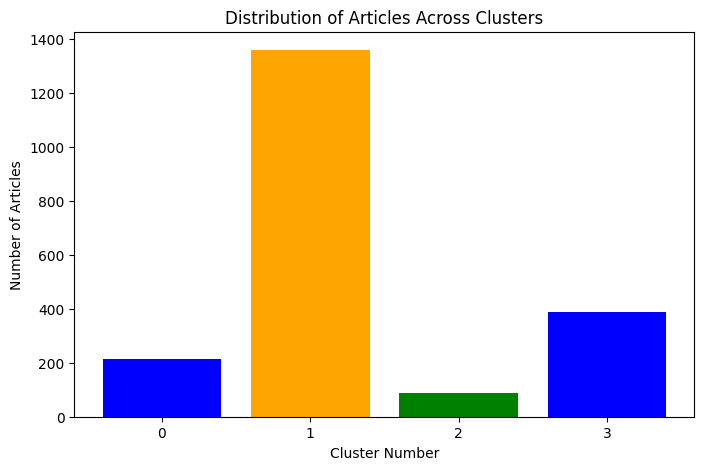

In [ ]:
import matplotlib.pyplot as plt

# Count the number of articles per cluster
cluster_counts = df['cluster'].value_counts().sort_index()

# Plot the cluster distribution
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color=['blue', 'orange', 'green'])
plt.xlabel("Cluster Number")
plt.ylabel("Number of Articles")
plt.title("Distribution of Articles Across Clusters")
plt.xticks(range(num_clusters))  # Ensure all clusters are labeled
plt.show()


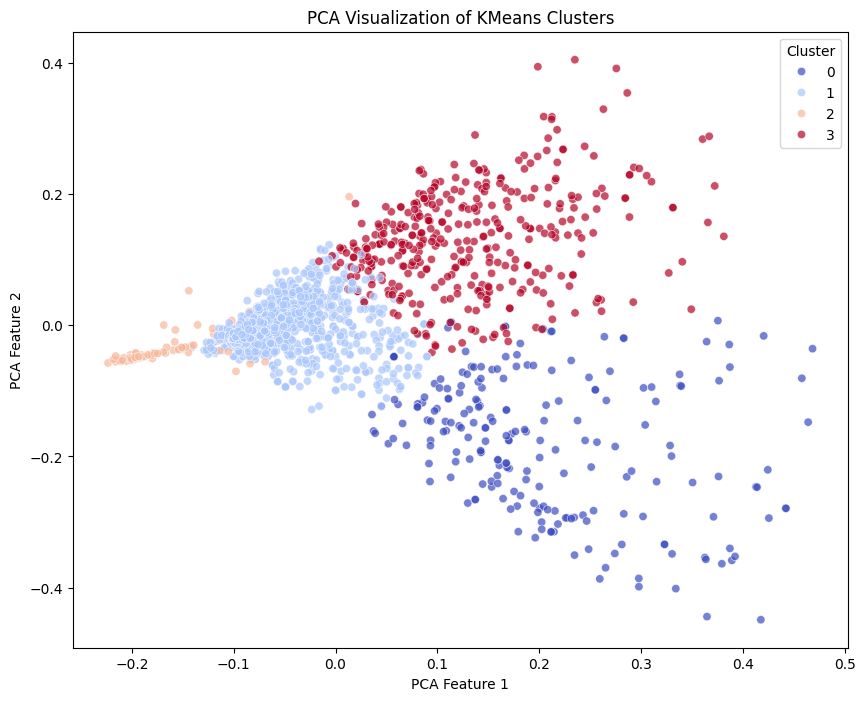

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Add PCA features to DataFrame
df['x-pca'] = X_pca[:, 0]
df['y-pca'] = X_pca[:, 1]

# Plot PCA clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x-pca', y='y-pca', hue=df['cluster'], palette='coolwarm', data=df, alpha=0.7)
plt.title('PCA Visualization of KMeans Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title="Cluster")
plt.show()


#LDA Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Convert TF-IDF vectorized data into count-based vectors
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_counts = count_vectorizer.fit_transform(df['processed_text'])

# Apply LDA for Topic Modeling
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_counts)

# Displaying topics
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\nLDA Topics:")
print_top_words(lda, count_vectorizer.get_feature_names_out())



LDA Topics:

Topic 1:
said, government, state, year, people, russia, food, country, war, military

Topic 2:
clinton, hillary, trump, election, email, campaign, said, fbi, state, republican

Topic 3:
trump, people, like, time, woman, life, dont, right, make, year


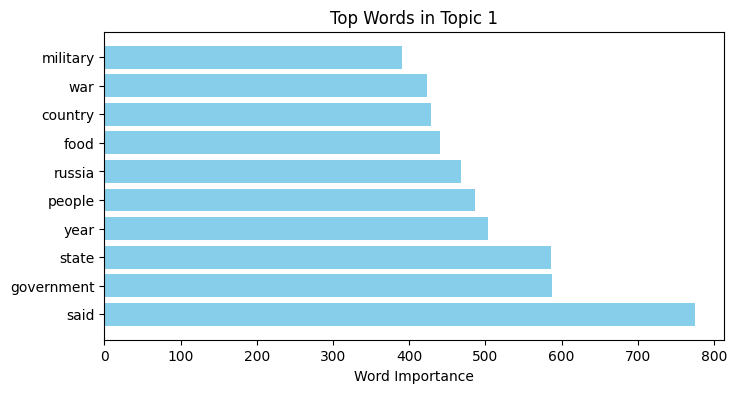

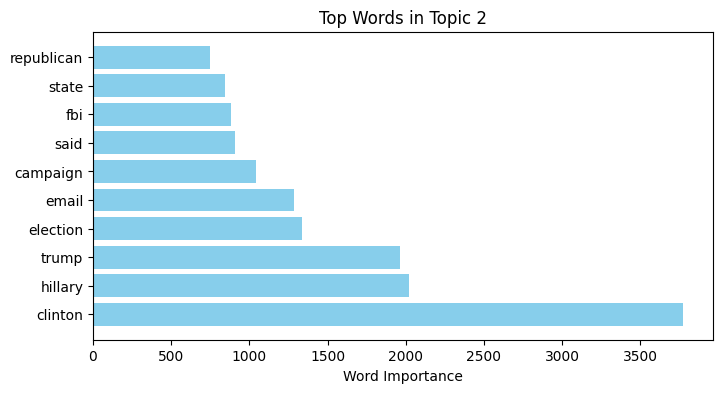

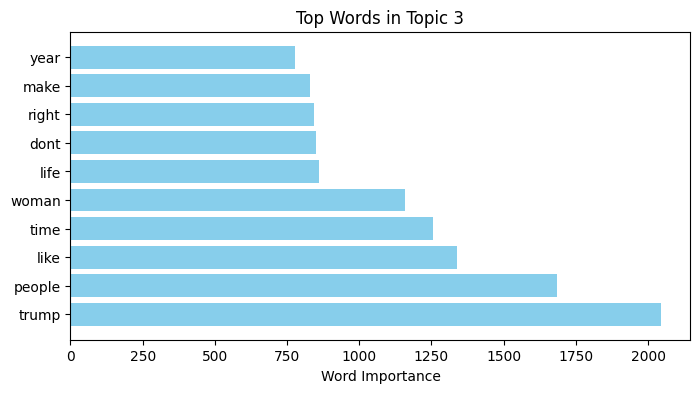

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get topic-word distribution
topic_word_distributions = lda.components_  # Shape: (num_topics, num_words)
feature_names = count_vectorizer.get_feature_names_out()

# Define number of words to display per topic
num_words = 10

# Plot bar chart for each topic
for topic_idx, topic in enumerate(topic_word_distributions):
    top_word_indices = topic.argsort()[-num_words:]  # Get top words
    top_words = [feature_names[i] for i in top_word_indices]
    top_values = topic[top_word_indices]  # Importance scores

    plt.figure(figsize=(8, 4))
    plt.barh(top_words, top_values, color='skyblue')
    plt.xlabel("Word Importance")
    plt.title(f"Top Words in Topic {topic_idx + 1}")
    plt.gca().invert_yaxis()  # Flip y-axis to show top words first
    plt.show()


#Sentiment Analysis/Polarity Analysis

label
Fake    0.061861
Real    0.044834
Name: sentiment1, dtype: float64
                                      processed_text  sentiment1
0  print pay back money plus interest entire fami...    0.000000
1  attorney general loretta lynch plead fifth bar...    0.012381
2  red state fox news sunday reported morning ant...    0.133333
3  email kayla mueller prisoner tortured isi chan...   -0.066667
4  email healthcare reform make america great sin...    0.149179


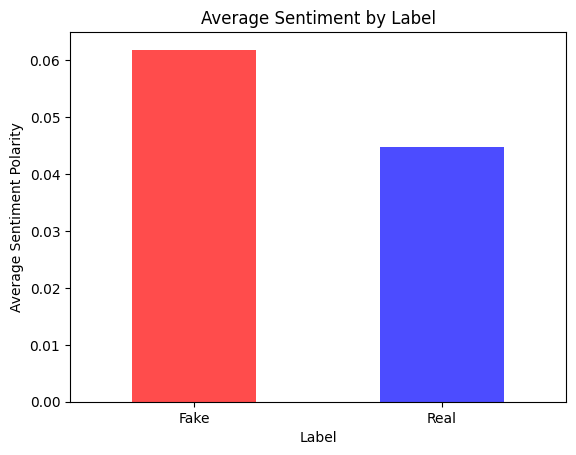

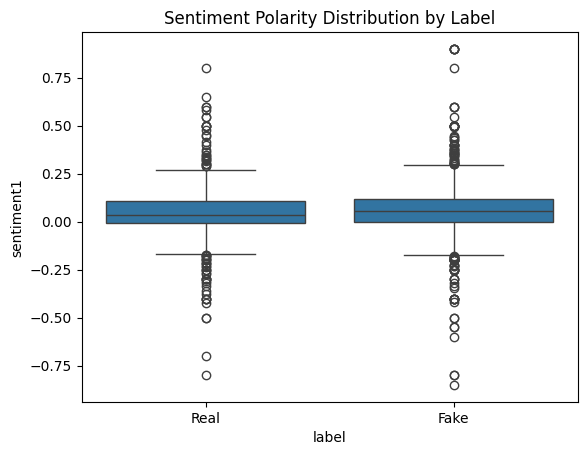

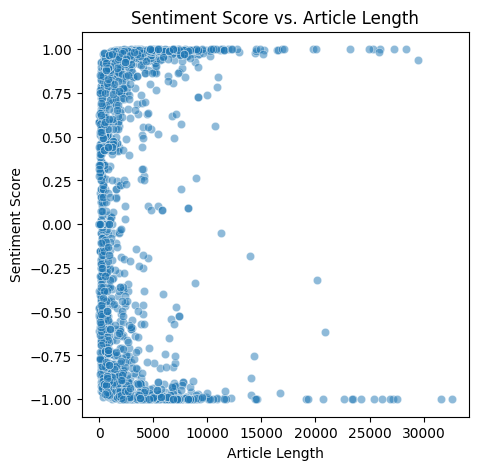

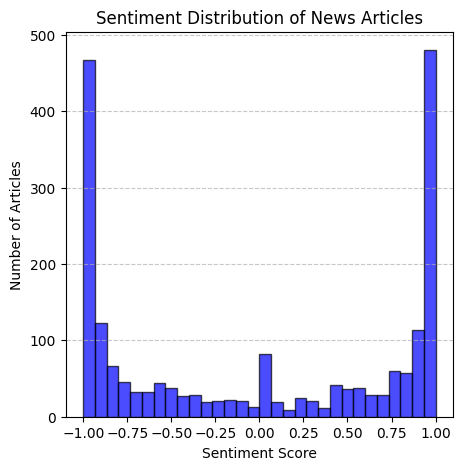

In [ ]:
# Add sentiment scores to the dataset
df['sentiment1'] = df['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group by 'label' to analyze sentiment trends
sentiment_by_label = df.groupby('label')['sentiment1'].mean()
print(sentiment_by_label)
print(df[['processed_text', 'sentiment1']].head())  # Verify sentiment values

#
sentiment_by_label.plot(kind='bar', color=['red', 'blue'], alpha=0.7)
plt.title("Average Sentiment by Label")
plt.ylabel("Average Sentiment Polarity")
plt.xlabel("Label")
plt.xticks(rotation=0)
plt.show()

#Sentiment Polarity Distribution by Label

sns.boxplot(x='label', y='sentiment1', data=df)
plt.title('Sentiment Polarity Distribution by Label')
plt.show()

#Sentiment Score vs. Article Length

df['text_length'] = df['text'].apply(len)
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['processed_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
plt.figure(figsize=(5,5))
sns.scatterplot(x=df['text_length'], y=df['sentiment'], alpha=0.5)
plt.xlabel("Article Length")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score vs. Article Length")
plt.show()

#Number of Articles vs sentiment score
plt.figure(figsize=(5,5))
plt.hist(df['sentiment'], bins=30, edgecolor='black', alpha=0.7, color='blue')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Articles')
plt.title('Sentiment Distribution of News Articles')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





#Vectorization

In [ ]:
#create 3 vectors for apply different models

#  unigram term frequency vectorizer, set minimum document frequency to 5
unigram_count_vectorizer = CountVectorizer(encoding='latin-1', binary=False, min_df=5,stop_words=stopwords.words('english'))

#  Unigram, bigram and trigram term frequency vectorizer, set minimum document frequency to 1
ngram_count_vectorizer = CountVectorizer(encoding='latin-1', ngram_range=(1,3), min_df=1,stop_words=stopwords.words('english'))

#  unigram tfidf vectorizer, set minimum document frequency to 1
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=1,stop_words=stopwords.words('english'))

Feature set in these 3 vectorizor

In [ ]:
feature_names_unigram=unigram_count_vectorizer.fit_transform(df['processed_text'])
feature_names_ngram=ngram_count_vectorizer.fit_transform(df['processed_text'])
feature_names_tfidf=unigram_tfidf_vectorizer.fit_transform(df['processed_text'])

spliting data in train and test

In [ ]:
y=df['label'].values
X=df['processed_text'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0])
print(y_train[0])
print(X_test[0])
print(y_test[0])

(1434,) (1434,) (615,) (615,)
jack burn wikileaks helping president obama keep campaign promise transparent administration u history whether like
Fake
david rives archive david rives known presentation heaven declare glory god host tbns creation st century gps telescope allows david share passion heaven others astronomical event heaven declare yes creationists real scientist exclusive david rives offer testable hypothesis supported data biblebelievers
Real


In [ ]:
# fit vocabulary in training documents and transform the training documents into vectors
X_train_unigram = unigram_count_vectorizer.fit_transform(X_train)
X_train_ngram = ngram_count_vectorizer.fit_transform(X_train)
X_train_tfidf = unigram_tfidf_vectorizer.fit_transform(X_train)

#vectorize test data
X_test_unigram = unigram_count_vectorizer.transform(X_test)
X_test_ngram = ngram_count_vectorizer.transform(X_test)
X_test_tfidf = unigram_tfidf_vectorizer.transform(X_test)

#Model

In [ ]:
# initialize the MNB model
nb_clf= MultinomialNB()
nb_clf_ngram= MultinomialNB()
nb_clf_tfidf= MultinomialNB()

fit model to training data

In [ ]:
# use the training data to train the MNB model
nb_clf.fit(X_train_unigram, y_train)
nb_clf_ngram.fit(X_train_ngram, y_train)
nb_clf_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

#Evaluation/Result

In [ ]:
# test the classifier on the test data set

y_pred_unigram = nb_clf.predict(X_test_unigram)
y_pred_ngram = nb_clf_ngram.predict(X_test_ngram)
y_pred_tfidf = nb_clf_tfidf.predict(X_test_tfidf)


create a function for print confusion matrix

In [ ]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title(title)
    plt.show()

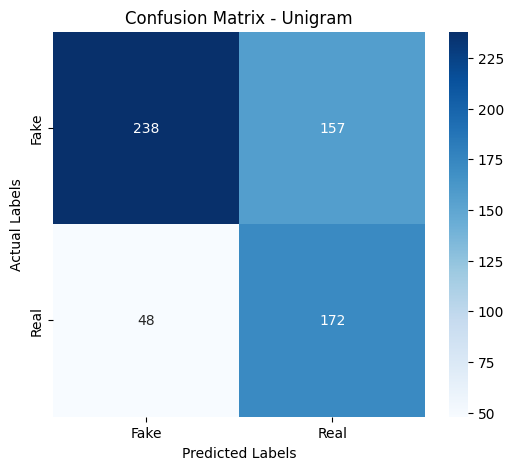

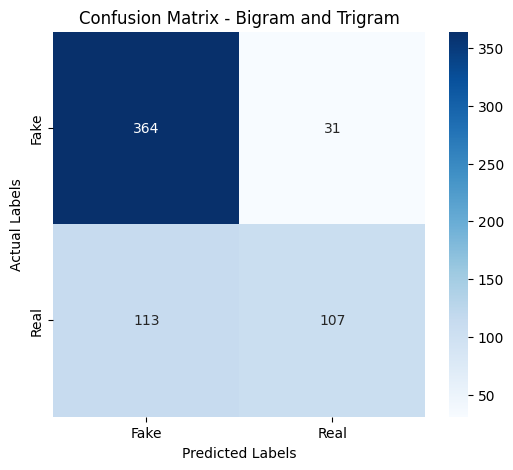

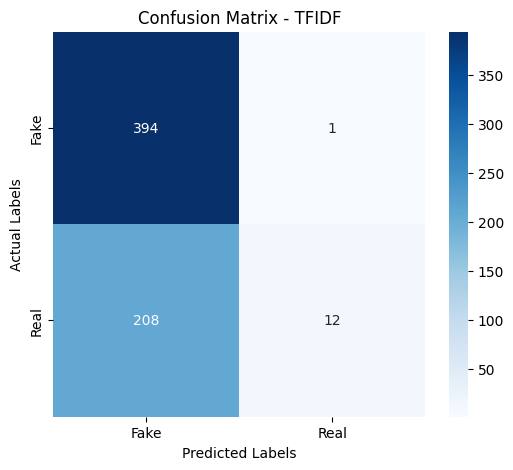

In [ ]:
#plot confusion Matrix
cm_unigram = confusion_matrix(y_test, y_pred_unigram)
cm_ngram = confusion_matrix(y_test, y_pred_ngram)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

plot_confusion_matrix(cm_unigram, ['Fake', 'Real'], 'Confusion Matrix - Unigram')
plot_confusion_matrix(cm_ngram, ['Fake', 'Real'], 'Confusion Matrix - Bigram and Trigram')
plot_confusion_matrix(cm_tfidf, ['Fake', 'Real'], 'Confusion Matrix - TFIDF')

In [ ]:
#print score
print("Score")
print(f"Unigram Vector:{nb_clf.score(X_test_unigram,y_test):.2f}")
print(f"N-gram Vector:{nb_clf_ngram.score(X_test_ngram,y_test):.2f}")
print(f"Tf-IDF Vector:{nb_clf_tfidf.score(X_test_tfidf,y_test):.2f}")

#print classification Report
print(classification_report(y_test, y_pred_unigram))
print(classification_report(y_test, y_pred_ngram))
print(classification_report(y_test, y_pred_tfidf))


Score
Unigram Vector:0.67
N-gram Vector:0.77
Tf-IDF Vector:0.66
              precision    recall  f1-score   support

        Fake       0.83      0.60      0.70       395
        Real       0.52      0.78      0.63       220

    accuracy                           0.67       615
   macro avg       0.68      0.69      0.66       615
weighted avg       0.72      0.67      0.67       615

              precision    recall  f1-score   support

        Fake       0.76      0.92      0.83       395
        Real       0.78      0.49      0.60       220

    accuracy                           0.77       615
   macro avg       0.77      0.70      0.72       615
weighted avg       0.77      0.77      0.75       615

              precision    recall  f1-score   support

        Fake       0.65      1.00      0.79       395
        Real       0.92      0.05      0.10       220

    accuracy                           0.66       615
   macro avg       0.79      0.53      0.45       615
weighted a

#Top 20 important feature for each model

<ipython-input-30-be3e17c4ee9f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance Score", y="Word", data=df_word_importance_unigram, palette="Blues_r")


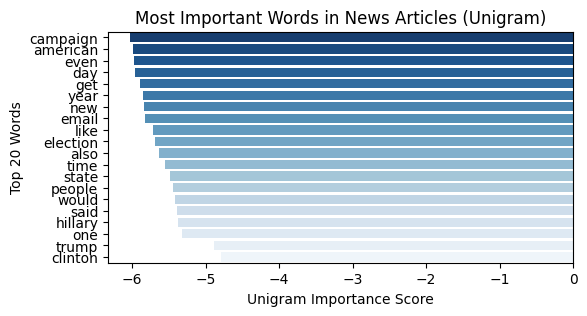

<ipython-input-30-be3e17c4ee9f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance Score', y='Word', data=df_word_importance_ngram, palette="Blues_r")


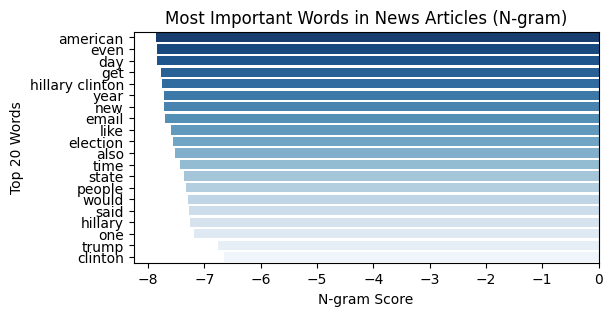

<ipython-input-30-be3e17c4ee9f>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance Score', y='Word', data=df_word_importance_tfidf, palette="Blues_r")


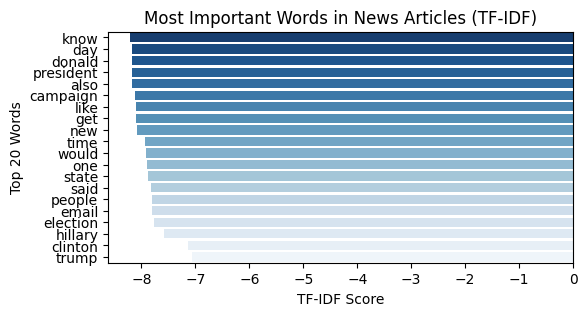

In [ ]:
#For Unigram Vectorizor

feature_ranks_nb_unigram = sorted(zip(nb_clf.feature_log_prob_[0], unigram_count_vectorizer.get_feature_names_out()))

word_importance_unigram = feature_ranks_nb_unigram[-20:]
# Convert word importance data to DataFrame
df_word_importance_unigram = pd.DataFrame(word_importance_unigram, columns=["Importance Score", "Word"])

# Plot bar chart for unigram word importance
plt.figure(figsize=(6, 3))
sns.barplot(x="Importance Score", y="Word", data=df_word_importance_unigram, palette="Blues_r")
plt.xlabel("Unigram Importance Score")
plt.ylabel("Top 20 Words")
plt.title("Most Important Words in News Articles (Unigram)")
plt.show()


#For N-gram Vectorizer
feature_ranks_nb_ngram=sorted(zip(nb_clf_ngram.feature_log_prob_[0],ngram_count_vectorizer.get_feature_names_out()))
word_importance_ngram = feature_ranks_nb_ngram[-20:]
# Convert word importance data to DataFrame
df_word_importance_ngram = pd.DataFrame(word_importance_ngram, columns=["Importance Score", "Word"])
plt.figure(figsize=(6,3))
sns.barplot(x='Importance Score', y='Word', data=df_word_importance_ngram, palette="Blues_r")
plt.xlabel("N-gram Score")
plt.ylabel("Top 20 Words")
plt.title("Most Important Words in News Articles (N-gram)")
plt.show()

#For Tf-IDF Vectorizer
feature_ranks_nb_tfidf=sorted(zip(nb_clf_tfidf.feature_log_prob_[0],unigram_tfidf_vectorizer.get_feature_names_out()))
word_importance_tfidf = feature_ranks_nb_tfidf[-20:]
# Convert word importance data to DataFrame
df_word_importance_tfidf = pd.DataFrame(word_importance_tfidf, columns=["Importance Score", "Word"])
plt.figure(figsize=(6,3))
sns.barplot(x='Importance Score', y='Word', data=df_word_importance_tfidf, palette="Blues_r")
plt.xlabel("TF-IDF Score")
plt.ylabel("Top 20 Words")
plt.title("Most Important Words in News Articles (TF-IDF)")
plt.show()


#cross validation for above vectorizers

In [ ]:

# Define cross-validation folds (e.g., 10-fold)
cv_folds = 10

# Apply vectorizers to the entire dataset
X_unigram = unigram_count_vectorizer.fit_transform(df['processed_text'])
X_ngram = ngram_count_vectorizer.fit_transform(df['processed_text'])
X_tfidf = unigram_tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['label'].values  # Target labels

# Initialize Models
nb_clf_cv = MultinomialNB()
nb_clf_ngram_cv = MultinomialNB()
nb_clf_tfidf_cv = MultinomialNB()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores_unigram = cross_val_score(nb_clf_cv, X_unigram, y, cv=skf, scoring='accuracy')
cv_scores_ngram = cross_val_score(nb_clf_ngram_cv, X_ngram, y, cv=skf, scoring='accuracy')
cv_scores_tfidf = cross_val_score(nb_clf_tfidf_cv, X_tfidf, y, cv=skf, scoring='accuracy')

# Print Cross-Validation Scores and Accuracy
print("Cross-Validation Scores:")
print(f"Unigram Vector: {cv_scores_unigram}")
print("Accuracy:", cv_scores_unigram.mean())
print(f"N-gram Vector: {cv_scores_ngram}")
print("Accuracy:", cv_scores_ngram.mean())
print(f"Tf-IDF Vector: {cv_scores_tfidf}")
print("Accuracy:", cv_scores_tfidf.mean())


Cross-Validation Scores:
Unigram Vector: [0.65365854 0.68780488 0.66341463 0.67317073 0.71219512 0.65853659
 0.72682927 0.65365854 0.71219512 0.67647059]
Accuracy: 0.681793400286944
N-gram Vector: [0.62926829 0.71219512 0.6195122  0.67317073 0.63902439 0.68780488
 0.66341463 0.70731707 0.66829268 0.66666667]
Accuracy: 0.6666666666666666
Tf-IDF Vector: [0.64878049 0.64878049 0.63902439 0.65365854 0.65853659 0.66829268
 0.64390244 0.65365854 0.67804878 0.65686275]
Accuracy: 0.6549545671927308


#SVM Model

# SMV model Ngram features with a linear kernel

SVM using Unigram, bigram and trigram features with a linear kernel 67.31%

SVM Accuracy: 0.6731707317073171
Classification Report:
               precision    recall  f1-score   support

        Fake       0.75      0.73      0.74       395
        Real       0.54      0.56      0.55       220

    accuracy                           0.67       615
   macro avg       0.65      0.65      0.65       615
weighted avg       0.68      0.67      0.67       615



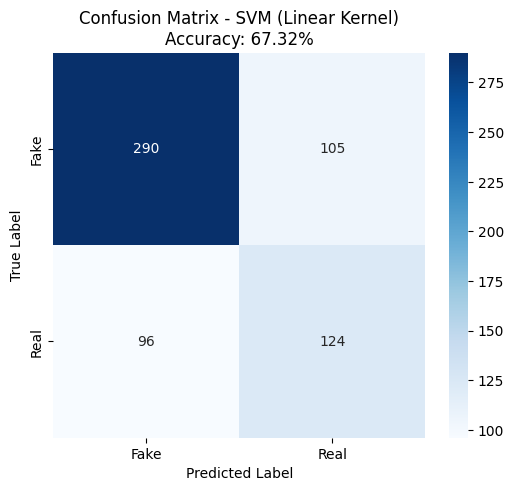

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model using unigram vectorized training data
svm_model.fit(X_train_unigram, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_unigram)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels for Fake vs. Real
labels = ['Fake', 'Real']

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SVM (Linear Kernel)\nAccuracy: {accuracy:.2%}")
plt.show()

#SVM Model Ngrams using RBF kernel

SVM Model using rbf kernel with the same Unigram, bigram and trigrams features 68.45%

SVM with RBF Kernel Accuracy: 0.6845528455284553
Classification Report:
               precision    recall  f1-score   support

        Fake       0.68      0.95      0.79       395
        Real       0.70      0.20      0.32       220

    accuracy                           0.68       615
   macro avg       0.69      0.58      0.56       615
weighted avg       0.69      0.68      0.62       615



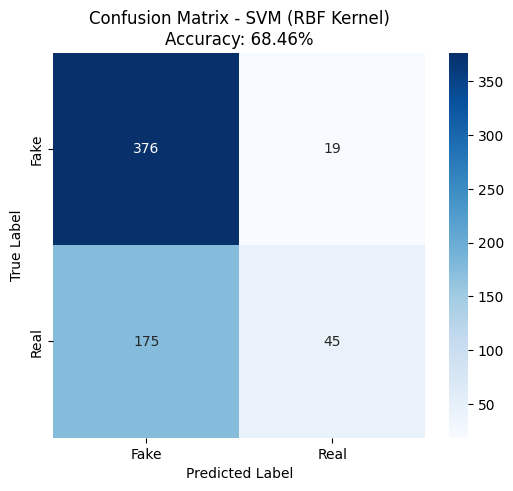

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM model with RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=43)

# Train the model using unigram vectorized training data
svm_rbf.fit(X_train_unigram, y_train)

# Predict on the test set
y_pred_rbf = svm_rbf.predict(X_test_unigram)

# Evaluate the model
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("SVM with RBF Kernel Accuracy:", accuracy_rbf)
print("Classification Report:\n", classification_report(y_test, y_pred_rbf))

# Compute the confusion matrix
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)

# Define class labels for Fake vs. Real
labels = ['Fake', 'Real']

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_rbf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SVM (RBF Kernel)\nAccuracy: {accuracy_rbf:.2%}")
plt.show()



#SVM MODEL Boolean features and RBF Kernel

SVM Model using Boolean feaures and RBF kernel 72.36% accuracy

SVM with RBF Kernel (Boolean Features) Accuracy: 0.7235772357723578
Classification Report:
               precision    recall  f1-score   support

        Fake       0.70      0.98      0.82       395
        Real       0.88      0.26      0.41       220

    accuracy                           0.72       615
   macro avg       0.79      0.62      0.61       615
weighted avg       0.77      0.72      0.67       615



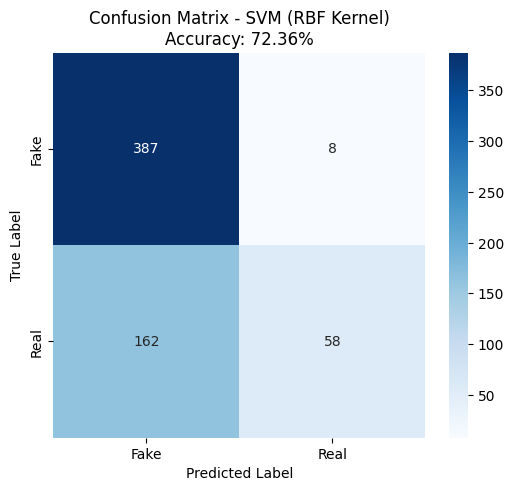

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a CountVectorizer with binary features (Boolean representation)
bool_vectorizer = CountVectorizer(binary=True)

# Fit and transform the training data
X_train_bool = bool_vectorizer.fit_transform(X_train)

# Transform the test data (DO NOT FIT AGAIN)
X_test_bool = bool_vectorizer.transform(X_test)

# Initialize the SVM model with RBF kernel
svm_rbf_bool = SVC(kernel='rbf', random_state=44)

# Train the model using Boolean vectorized training data
svm_rbf_bool.fit(X_train_bool, y_train)

# Predict on the test set
y_pred_rbf_bool = svm_rbf_bool.predict(X_test_bool)

# Evaluate the model
accuracy_rbf_bool = accuracy_score(y_test, y_pred_rbf_bool)
print("SVM with RBF Kernel (Boolean Features) Accuracy:", accuracy_rbf_bool)
print("Classification Report:\n", classification_report(y_test, y_pred_rbf_bool))

# Compute the confusion matrix
conf_matrix_rbf_bool = confusion_matrix(y_test, y_pred_rbf_bool)

# Define class labels for Fake vs. Real
labels = ['Fake', 'Real']

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_rbf_bool, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SVM (RBF Kernel)\nAccuracy: {accuracy_rbf_bool:.2%}")
plt.show()


#SVM Model Boolean features and liner Kernel

SVM accuracy 70.57%

SVM with Linear Kernel (Boolean Features) Accuracy: 0.7056910569105691
Classification Report:
               precision    recall  f1-score   support

        Fake       0.78      0.76      0.77       395
        Real       0.59      0.60      0.60       220

    accuracy                           0.71       615
   macro avg       0.68      0.68      0.68       615
weighted avg       0.71      0.71      0.71       615



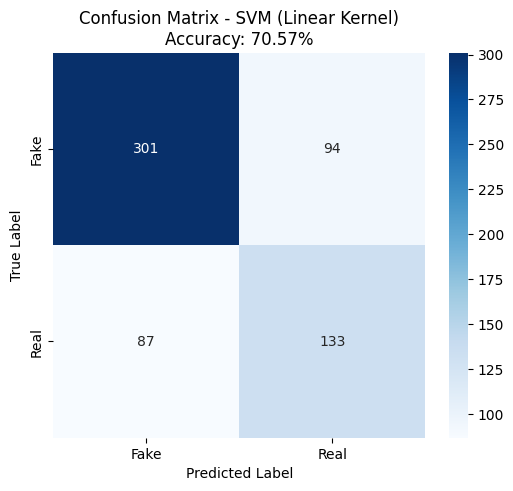

In [ ]:
svm_linear_bool = SVC(kernel='linear', random_state=45)

# Train the model using Boolean vectorized training data
svm_linear_bool.fit(X_train_bool, y_train)

# Predict on the test set
y_pred_linear_bool = svm_linear_bool.predict(X_test_bool)

# Evaluate the model
accuracy_linear_bool = accuracy_score(y_test, y_pred_linear_bool)
print("SVM with Linear Kernel (Boolean Features) Accuracy:", accuracy_linear_bool)
print("Classification Report:\n", classification_report(y_test, y_pred_linear_bool))

# Compute the confusion matrix
conf_matrix_linear_bool = confusion_matrix(y_test, y_pred_linear_bool)

# Define class labels for Fake vs. Real
labels = ['Fake', 'Real']

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_linear_bool, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - SVM (Linear Kernel)\nAccuracy: {accuracy_linear_bool:.2%}")  # Display accuracy as percentage
plt.show()

#Best Cross-Validation Accuracy (0.7043)
This is the average accuracy during GridSearchCV's 5-fold cross-validation. It indicates how well the model performed on different training/validation splits. Used for hyperparameter tuning but not on the final test set.

#Best Model Test Accuracy (0.7658)
This is the accuracy of the final trained model on the test set (X_test_bool). It represents the model's actual performance on unseen data. This is the most important accuracy for evaluating real-world performance.


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # RBF kernel gamma options
}

# Initialize the SVM model with RBF kernel
svm_rbf_bool = SVC(kernel='rbf', random_state=46)

# Perform Grid Search with 5-Fold Cross-Validation
grid_search = GridSearchCV(svm_rbf_bool, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_bool, y_train)

# Print best parameters
print("Best Parameters Found:", grid_search.best_params_)

# Get the best cross-validation accuracy
best_cv_accuracy = grid_search.best_score_
print("Best Cross-Validation Accuracy:", best_cv_accuracy)

# Train the best model on full training data
best_svm_rbf_bool = grid_search.best_estimator_
best_svm_rbf_bool.fit(X_train_bool, y_train)

# Predict on the test set
y_pred_best = best_svm_rbf_bool.predict(X_test_bool)

# Evaluate the best model
test_accuracy = accuracy_score(y_test, y_pred_best)
print("Best Model Test Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_best))





Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters Found: {'C': 10, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.7043151969981238
Best Model Test Accuracy: 0.7658536585365854
Classification Report:
               precision    recall  f1-score   support

        Fake       0.79      0.86      0.83       395
        Real       0.71      0.59      0.64       220

    accuracy                           0.77       615
   macro avg       0.75      0.73      0.73       615
weighted avg       0.76      0.77      0.76       615



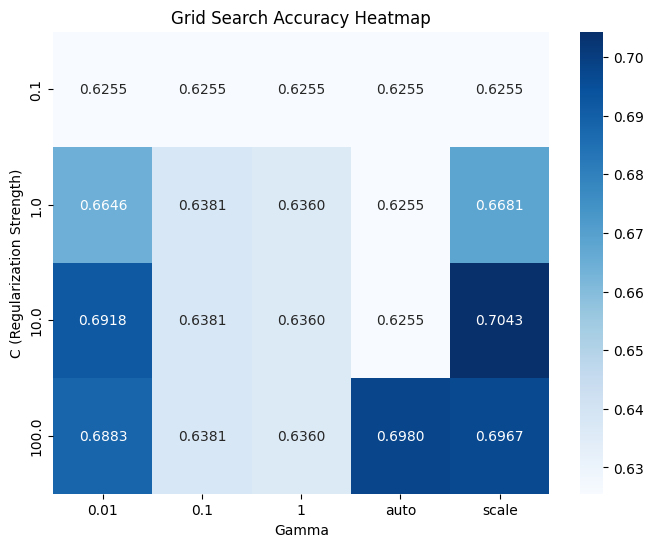

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert grid search results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot table for heatmap visualization
heatmap_data = results_df.pivot(index='param_C', columns='param_gamma', values='mean_test_score')

# Convert index/columns to numeric values
heatmap_data.index = heatmap_data.index.astype(float)
heatmap_data.columns = heatmap_data.columns.astype(str)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="Blues")
plt.xlabel("Gamma")
plt.ylabel("C (Regularization Strength)")
plt.title("Grid Search Accuracy Heatmap")
plt.show()


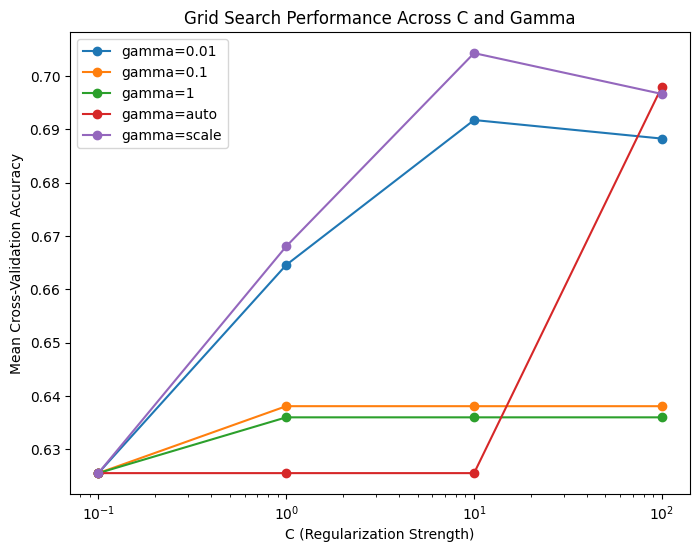

In [ ]:
import matplotlib.pyplot as plt

# Sort results for a clean visualization
results_df = results_df.sort_values(by=['param_C', 'param_gamma'])

# Pivot results into a format for line plot
plt.figure(figsize=(8,6))

for gamma_val in results_df['param_gamma'].unique():
    subset = results_df[results_df['param_gamma'] == gamma_val]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'gamma={gamma_val}')

plt.xscale('log')  # Since C is usually logarithmic
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("Grid Search Performance Across C and Gamma")
plt.legend()
plt.show()



Confusion Matrix:
[[341  54]
 [ 90 130]]

Best Model Test Accuracy: 0.7658536585365854

Classification Report:
              precision    recall  f1-score   support

        Fake       0.79      0.86      0.83       395
        Real       0.71      0.59      0.64       220

    accuracy                           0.77       615
   macro avg       0.75      0.73      0.73       615
weighted avg       0.76      0.77      0.76       615



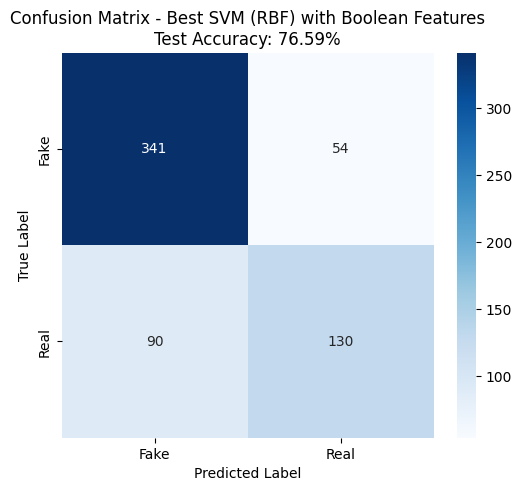

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Define class labels for Fake vs. Real
labels = ['Fake', 'Real']

# Print Confusion Matrix with Accuracy
print("\nConfusion Matrix:")
print(conf_matrix_best)

# Print Test Accuracy
print("\nBest Model Test Accuracy:", test_accuracy)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Best SVM (RBF) with Boolean Features\nTest Accuracy: {test_accuracy:.2%}")
plt.show()
